# Redrock Classifications and Redshifts

[Redrock](https://github.com/desihub/redrock) is the code that DESI uses for spectral classifications and redshifts.
The basic method is to fit a variety of Principal Component Analysis (PCA) templates to each target over a range of redshifts,
and then report the template spectral type and redshift of the combination with the lowest chi2.

This tutorial will show how to use the Redrock output files, including understanding the formats and using the data
to generate the best fit model spectrum for a target.

It will start by analyzing Redrock output without using any DESI-specific code,
and then will show how to simplify that work by using DESI-specific code.

## Imports

In [141]:
import os
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt

## DESI data location

Although we won't use any DESI code yet, we do need some DESI data.
We'll find this using the $DESI_ROOT environment variable so that the tutorial is portable to different computing sites.
See the [01_getting_started/00_Setup.md](../01_getting_started/00_Setup.md) script for information
on how to download a subset of DESI data for these tutorials.

In [142]:
# os.environ['DESI_ROOT'] = /path/to/where/you/have/desidata
# see 01_getting_started/00_Setup.md

if 'DESI_ROOT' not in os.environ:
    errmsg = "Please set $DESI_ROOT to location of DESI data prior to running this tutorial"
    raise(RuntimeError(errmsg))

assert os.path.isdir(os.environ['DESI_ROOT'])
print(f"Using $DESI_ROOT={os.environ['DESI_ROOT']}")

Using $DESI_ROOT=/Users/sbailey/desi/tiny_dr1/


## Redrock file format

Redrock files are stored in the same directories as the DESI spectra and coadds.
Let's inspect the same healpix-grouped spectra that we used in the [01_getting_started](../01_getting_started) tutorials.

In [143]:
#- hardcode values for data included in the tiny_dr1 subset for tutorials
specprod = 'iron'
healpix = 23040
survey = 'main'
program = 'dark'

#- Construct the paths to the coadd and redrock files
specprod_dir = os.path.expandvars(f'$DESI_ROOT/spectro/redux/{specprod}')
hpix_dir = f'{specprod_dir}/healpix/{survey}/{program}/{healpix//100}/{healpix}'
coaddfile = f'{hpix_dir}/coadd-{survey}-{program}-{healpix}.fits'
redrockfile = f'{hpix_dir}/redrock-{survey}-{program}-{healpix}.fits'

In [144]:
print(f'Contents of {redrockfile}')
with fitsio.FITS(redrockfile) as fp:
    print(fp)

Contents of /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/healpix/main/dark/230/23040/redrock-main-dark-23040.fits

  file: /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/healpix/main/dark/230/23040/redrock-main-dark-23040.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      REDSHIFTS
  2      BINARY_TBL      FIBERMAP
  3      BINARY_TBL      EXP_FIBERMAP
  4      BINARY_TBL      TSNR2


The redrock file contains a blank HDU 0, and 4 extensions:
  * **REDSHIFTS**: This table contains the core Redrock output
  * **FIBERMAP**: Propagated from the input coadd file
  * **EXP_FIBERMAP**: Propagated from the input coadd file
  * **TSNR2**: the TSNR2 columns from the input coadd SCORES HDU

The FIBERMAP, EXP_FIBERMAP, and TSNR2 HDUs are provided for convenience to make the redrock files more standalone,
without having to also read information from the much larger input coadd files.

Let's inspect the REDSHIFTS HDU, since this is the core output of Redrock:

In [145]:
#- Read REDSHIFTS table
zcat = Table(fitsio.read(redrockfile, 'REDSHIFTS'))

#- Detail: limit precision of output format so all columns fit when printed
for col in zcat.colnames:
    if zcat[col].dtype.kind == 'f':
        zcat[col].format = '.4f'

#- Print the first few rows
zcat[0:10]

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,str6,str20,int64,float64
39627568982263324,1.9007,0.0011,0,8197.1915,0.3538 .. 0.0000,7924,QSO,HIZ,4,34.1186
-24360048,0.4351,0.0001,1,7770.9412,-29.2482 .. 0.5724,7920,GALAXY,,10,27.0560
39627568982265273,0.7810,0.0001,0,7825.6263,63.4188 .. 12.2475,7915,GALAXY,,10,109.3681
39627574954954792,0.6445,0.0000,0,7958.3556,42.2810 .. 11.3575,7923,GALAXY,,10,260.5293
39627568982264421,0.4865,0.0001,4,8398.9283,22.6320 .. -2.6046,7926,GALAXY,,10,5.8977
39627568982262838,1.8589,0.0019,0,7995.2389,0.3657 .. 0.0000,7922,QSO,HIZ,4,56.4906
39627568982262486,0.4485,0.0000,0,8549.6087,37.6507 .. -6.5724,7924,GALAXY,,10,626.3802
39627568982263659,0.0870,0.0003,0,8095.2677,0.3030 .. 0.0000,7923,QSO,LOZ,4,46.7344
39627563017965053,0.6857,0.0002,0,8219.4986,137.4169 .. 23.9620,7923,GALAXY,,10,274.6544


The REDSHIFTS table has the following columns:

* **TARGETID**: unique DESI target identifier, useful for crossmatching with other catalogs
* **Z**: Redshift
* **ZERR**: Estimated redshift error (Gaussian sigma)
* **ZWARN**: Bitmask of problems with the redshift fit; 0 is good
* **CHI2**: The $\chi^2$ of the best fit model
* **COEFF**: the coefficients of the best fit PCA model
* **NPIXELS**: the number of unmasked wavelength pixels included in the fit
* **SPECTYPE**: the spectral classification: GALAXY, QSO, or STAR
* **SUBTYPE**: some classifications have separate templates split by sub-type; blank string if not-applicable
* **NCOEFF**: number of PCA template vectors for the best-fit model
* **DELTACHI2**: The difference in $\chi^2$ between the best model and the second-best model.  Larger is better.

### SPECTYPE, SUBTYPE
The various **SPECTYPE**,**SUBTYPE** combinations reflect the templates used to fit these data.
Let's see what combinations are in these data.

In [146]:
for spectype in np.unique(zcat['SPECTYPE']):
    ii = (zcat['SPECTYPE'] == spectype)
    subtypes = list(np.unique(zcat['SUBTYPE'][ii]))
    print(f'SPECTYPE={spectype} has SUBTYPEs={subtypes}')

SPECTYPE=GALAXY has SUBTYPEs=['']
SPECTYPE=QSO has SUBTYPEs=['HIZ', 'LOZ']
SPECTYPE=STAR has SUBTYPEs=['F', 'G', 'K', 'M', 'WD']


Note that there are additional stellar subtypes that are fit; it's just that none of them were the best fit model for the data in this file.

### Z, ZWARN, ZERR

**Z** is the redshift of the best fit template.

**ZWARN** is a bit mask of known problems that occur during the fit.  For most purposes, analyses should
treat **0=good and discard any data with ZWARN!=0**.
The full set of ZWARN bits are documented in the [DESI datamodel](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#zwarn-bit-definitions);
these include fibers that are known to be broken (bit 7), entirely masked (bit 9), have a failed model fit (bit 10), or a low DELTACHI2 (bit 2).

**ZERR** is the estimated statistical uncertainty on the redshift fit from fitting a parabola around the minimum
in chi2 vs. z.  Since this does not include systematics, it is an underestimate of the true error.

### COEFF, NCOEFF

Each row of the **COEFF** column is itself an array of coefficients to apply to the PCA model vectors (more on that below).
The size of this array is set by the number of PCA vectors in the largest template.  Since other templates have fewer
model vectors, the **NCOEFF** value indicates how many entries of **COEFF** are actually used.
In principle it is possible that different **SUBTYPE**s of the same **SPECTYPE** could use different number of coefficients.
That doesn't happen to be the case with the current templates, but different **SPECTYPE**s do have different **NCOEFF**.

In [147]:
for spectype in np.unique(zcat['SPECTYPE']):
    ii = (zcat['SPECTYPE'] == spectype)
    ncoeff_options = list(np.unique(zcat['NCOEFF'][ii]))
    print(f'SPECTYPE={spectype} fits used {ncoeff_options} coefficients')

SPECTYPE=GALAXY fits used [10] coefficients
SPECTYPE=QSO fits used [4] coefficients
SPECTYPE=STAR fits used [5] coefficients


### CHI2, NPIXELS, DELTACHI2

**CHI** and **NPIXELS** give the $\chi^2$ and number of unmasked pixels included in the best fit.
Since the absolute $\chi^2$ is dominated by the systematics of how well the models represent the variability of the data,
the absolute $\chi^2$ isn't particularly useful.

What is more useful is the relative $\Delta \chi^2$ **DELTACHI2** between the best fit and the second best fit,
which gives a metric for how confident Redrock is that the reported best fit is uniquely the best answer.
A DELTACHI2<9 will set ZWARN bit 2, though many analyses prefer to put a stronger cut on DELTACHI2 to
achieve a purer sample, e.g. DELTACHI2>25.

## Relationship to redshift catalogs

The redshift catalogs in `$DESI_ROOT/spectro/redux/$SPECPROD/zcatalog/v1`
(described in [01_getting_started/04_RedshiftCatalogs.ipynb](../01_getting_started/04_RedshiftCatalogs.ipynb))
are basically a join of the Redrock REDSHIFTS, FIBERMAP, and TSNR2 tables, and then stacked across all files.
As such, the same columns described above can be accessed from the redshift catalogs as well.

If you already know which healpix or tile you want to use, it can save time by reading the data directly from the
much smaller `redrock-*.fits` file instead of the large zcatalog files.  This can also be effective for
"embarassingly parallel" programming, where different processes are each reponsible for a different healpix (or tile),
and read just the data they need from the redrock file and its corresponding coadd file.

On the other hand, if you want to start with all DESI targets and filter to a subset without having to read
N>>1 individual files, it can be more effective to start with the zcatalog files.

## Comparing spectra to Redrock fits

Let's now read the corresponding coadded spectra, and compare them with the Redrock bestfit model.

**WARNING**: without using `desispec` and `redrock` code, this is a bit of a pain, but we're going to
walk through the details for users to understand the underlying formats and details.  After this section
we'll show how to do the same using `desispec` and `redrock` utilities, which will be much simpler, albeit
more black-box.

### Read the coadded spectra

See [01_getting_started/01_QuickStart.ipynb](../01_getting_started/01_QuickStart.ipynb)
and [01_getting_started/05_Spectra.ipynb](../01_getting_started/05_Spectra.ipynb) for more details
about the coadded spectra data format.

In [148]:
wave = dict()
flux = dict()
ivar = dict()
with fitsio.FITS(coaddfile) as fp:
    fibermap = Table(fp['FIBERMAP'].read())
    for camera in ('b', 'r', 'z'):
        wave[camera] = fp[f'{camera}_WAVELENGTH'].read()
        flux[camera] = fp[f'{camera}_FLUX'].read()
        ivar[camera] = fp[f'{camera}_IVAR'].read()

# also read the redrock FIBERMAP for comparison
redrock_fibermap = Table.read(redrockfile, 'FIBERMAP')

First confirm that the redrock FIBERMAP is indeed the same as the coadd FIBERMAP, and that they
are row-matched to the REDSHIFTS (zcat) table by comparing TARGETID:

In [149]:
assert fibermap.colnames == redrock_fibermap.colnames
for col in fibermap.colnames:
    assert np.all(fibermap[col] == redrock_fibermap[col])

assert np.all(zcat['TARGETID'] == fibermap['TARGETID'])

### Filter to just QSO

Filter both the spectra and the fibermap to those confidently identified as QSOs.
Note that since all the arrays are row-matched, the same selection applies to all.

In [150]:
keep = (zcat['SPECTYPE'] == 'QSO') & (zcat['ZWARN'] == 0)

### keep = (zcat['SPECTYPE'] == 'GALAXY') & (zcat['ZWARN'] == 0)

zcat = zcat[keep]
fibermap = fibermap[keep]
for camera in flux.keys():
    flux[camera] = flux[camera][keep]
    ivar[camera] = ivar[camera][keep]

In [151]:
# pick the index of a nice QSO for plotting
itgt = 3

### Plot the spectra

Text(0.5, 1.0, 'QSO at z=3.091')

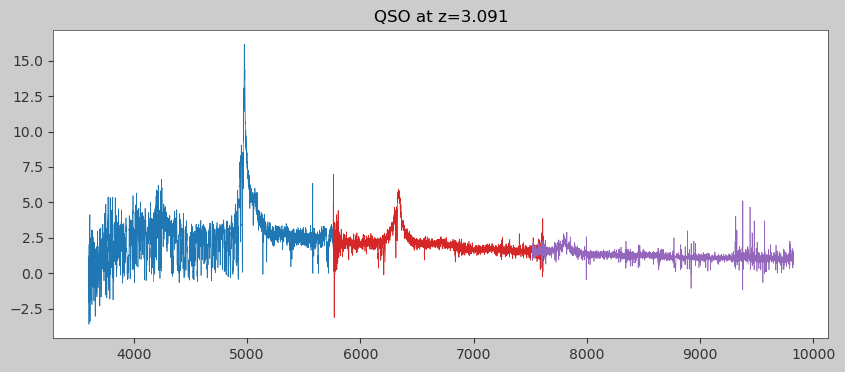

In [152]:
z = zcat['Z'][itgt]
spectype = zcat['SPECTYPE'][itgt]

plt.figure(figsize=(10,4))
for camera, color in [('b','C0'), ('r','C3'), ('z', 'C4')]:
    ok = ivar[camera][itgt]>0
    plt.plot(wave[camera][ok], flux[camera][itgt][ok], '-', color=color, lw=0.5)

plt.title(f'{spectype} at z={z:.3f}')

### Construct the Redrock model

In [153]:
row = zcat[itgt]
print(f"Target {row['TARGETID']} at index {itgt} has SPECTYPE={row['SPECTYPE']}, SUBTYPE={row['SUBTYPE']}, Z={row['Z']}")
print(f"It has {row['NCOEFF']} coefficients COEFF={row['COEFF'][0:row['NCOEFF']]}")

Target 39627563017964714 at index 3 has SPECTYPE=QSO, SUBTYPE=HIZ, Z=3.0909676562484925
It has 4 coefficients COEFF=[  1.34498999  50.09029548 -13.87926292   4.90306031]


First we have to find the matching PCA template vectors for that SPECTYPE,SUBTYPE.
This can be any location where you've downloaded or cloned a copy of https://github.com/desihub/redrock-templates.
If you've installed the Redrock code and run `install_redrock_templates` (see [01_getting_started/00_Setup.md](../01_getting_started/00_Setup.md))
then you already have a copy.  We'll try several options:

In [154]:
template_dir = None
if 'RR_TEMPLATE_DIR' in os.environ:
    template_dir = os.environ['RR_TEMPLATE_DIR']
else:
    try:
        import redrock.templates
        template_dir = redrock.templates.get_template_dir()
    except:
        pass

if template_dir is None:
    raise RuntimeError('Please clone https://github.com/desihub/redrock-templates or install redrock+templates before proceeding')

In [155]:
print(f'Contents of {template_dir}')
sorted(os.listdir(template_dir))

Contents of /Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates


['.git',
 'CHANGES.md',
 'LICENSE.md',
 'README.md',
 'etc',
 'rrtemplate-GALAXY-None-v2.6.fits',
 'rrtemplate-QSO-HIZ-v1.0.fits',
 'rrtemplate-QSO-HIZ-v1.1.fits',
 'rrtemplate-QSO-LOZ-v1.0.fits',
 'rrtemplate-QSO-None-v0.1.fits',
 'rrtemplate-STAR-A-v0.1.fits',
 'rrtemplate-STAR-B-v0.1.fits',
 'rrtemplate-STAR-CV-v0.1.fits',
 'rrtemplate-STAR-F-v0.1.fits',
 'rrtemplate-STAR-G-v0.1.fits',
 'rrtemplate-STAR-K-v0.1.fits',
 'rrtemplate-STAR-M-v0.1.fits',
 'rrtemplate-STAR-WD-v0.1.fits',
 'templates-0.7.2.txt',
 'templates-0.8.1.txt',
 'templates-0.8.txt',
 'templates-default.txt',
 'templates-fuji.txt',
 'templates-iron.txt']

The `rrtemplate-SPECTYPE-SUBTYPE-VERSION.fits` files are the templates themselves.
The `templates-*.txt` files record which templates were used for particular spectroscopic productions,
e.g. `iron` used for DR1.  So we'll need to inspect the templates file to find which QSO-HIZ template version to use.

In [156]:
with open(f'{template_dir}/templates-{specprod}.txt') as fp:
    print(''.join(fp.readlines()))

# Redrock templates 0.8
# Used for DESI Iron/DR1
rrtemplate-GALAXY-None-v2.6.fits
rrtemplate-QSO-LOZ-v1.0.fits
rrtemplate-QSO-HIZ-v1.0.fits
rrtemplate-STAR-A-v0.1.fits
rrtemplate-STAR-B-v0.1.fits
rrtemplate-STAR-CV-v0.1.fits
rrtemplate-STAR-F-v0.1.fits
rrtemplate-STAR-G-v0.1.fits
rrtemplate-STAR-K-v0.1.fits
rrtemplate-STAR-M-v0.1.fits
rrtemplate-STAR-WD-v0.1.fits



That used `rrtemplate-QSO-HIZ-v1.0.fits`.  We'll just hardcode this for the moment and read it.

In [157]:
templatefile = f'{template_dir}/rrtemplate-QSO-HIZ-v1.0.fits'
print(f'HDUs in {templatefile}')
with fitsio.FITS(templatefile) as fp:
    print(fp)
    hdr = fp[0].read_header()
    print('\nHDU0 header:')
    print(hdr)

HDUs in /Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-HIZ-v1.0.fits

  file: /Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-HIZ-v1.0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       BASIS_VECTORS
  1      IMAGE_HDU       REDSHIFTS

HDU0 header:

SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                  -64 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                10060 / 
NAXIS2  =                    4 / 
EXTEND  =                    T / 
CRVAL1  =               2.6471 / 
CDELT1  =               0.0001 / 
CRPIX1  =                    1 / 
CTYPE1  = 'log10(wavelength)'  / 
LOGLAM  =                    1 / 
RRTYPE  = 'QSO'                / 
RRSUBTYP= 'HIZ'                / 
VERSION = '1.0'                / Template version
RRVER   = '0.14.5'             / 
INSPEC 

The template file contains:
  * HDU0 "BASIS_VECTORS": PCA model vectors that we'll use to reconstruct the best fit
  * HDU1 "REDSHIFTS" (optional): the redshifts over which these templates should be scanned; used by Redrock when fitting data but not needed here.
  * Other HDUs may be present, e.g. to record the provenance of the training data
  * The HDU0 header contains keywords to specify the restframe wavelengths of the templates
    * if LOGLAM is present and non-0: `restwave = 10**(CRVAL1 + CDELT1*np.arange(NAXIS1))`
    * otherwise `restwave = CRVAL1 + CDELT1*np.arange(NAXIS1)`
  * The HDU0 header also contains keywords specifying the spectral classification type (RRTYPE), subtype (RRSUBTYP), and template version (VERSION).

We'll put these together into a helper-function for reading the templates.

In [158]:
def read_template(filename):
    """Read template from filename and return (pcavectors, restwave)"""
    basis_vectors, header = fitsio.read(filename, 'BASIS_VECTORS', header=True)
    nvec, nwave = basis_vectors.shape
    wave = header['CRVAL1'] + np.arange(nwave)*header['CDELT1']
    #- check if wavelength sampling is log(wave) instead of linear
    if 'LOGLAM' in header and header['LOGLAM'] != 0:
        wave = 10**wave

    return basis_vectors, wave

templatevec, templatewave = read_template(templatefile)

Plot the PCA template components

Text(0, 0.5, 'Template [arbitrary units]')

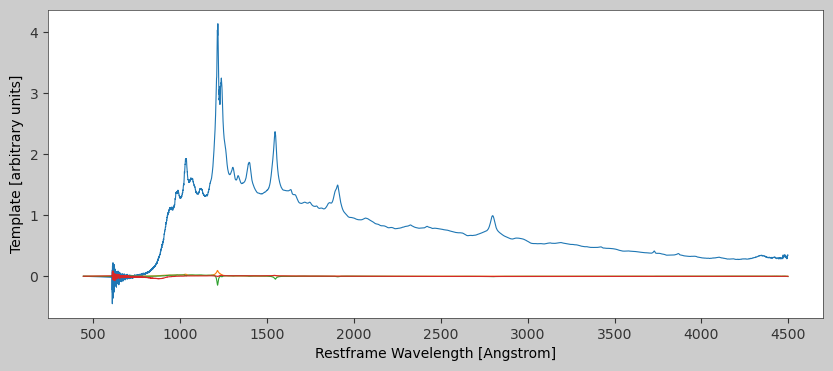

In [159]:
plt.figure(figsize=(10,4))
for i in range(templatevec.shape[0]):
    plt.plot(templatewave, templatevec[i], lw=0.8)
plt.xlabel('Restframe Wavelength [Angstrom]')
plt.ylabel('Template [arbitrary units]')

The unscaled templates are dominated by the 0th component with a mean QSO spectrum.
The scaling of the individual components is arbitrary, since any scale change would be absorbed by
the fitted coefficients.  Let's replot while re-scaling for better visualization.

Text(0, 0.5, 'Template [arbitrary units]')

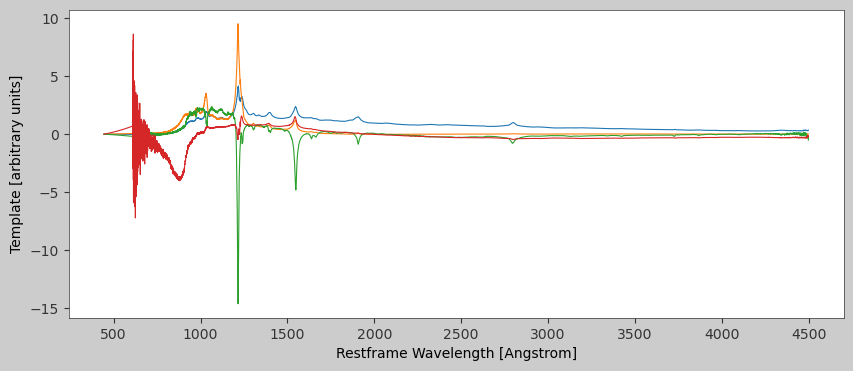

In [160]:
plt.figure(figsize=(10,4))
for i in range(templatevec.shape[0]):
    plt.plot(templatewave, templatevec[i] / np.sqrt(np.mean(templatevec[i]**2)), lw=0.8)
plt.xlabel('Restframe Wavelength [Angstrom]')
plt.ylabel('Template [arbitrary units]')

That's still not terribly informative, but gives a better sense of what wavelengths have key template features.
Note that the templates are noisy at the lower end, but this range of restframe wavelengths doesn't cover the DESI spectrographs until z>3.8.

Now we'll use the templates plus the fitted coefficients to generate the best fit model.

In [161]:
coeff = zcat['COEFF'][itgt]
z = zcat['Z'][itgt]
templatevec.shape, coeff.shape

((4, 10060), (10,))

In [162]:
nvec, ntemplatewave = templatevec.shape
assert nvec == zcat['NCOEFF'][itgt]
model = coeff[0:nvec].dot(templatevec)

Text(0, 0.5, 'Flux [1e-17 erg/s/cm2/Angstrom')

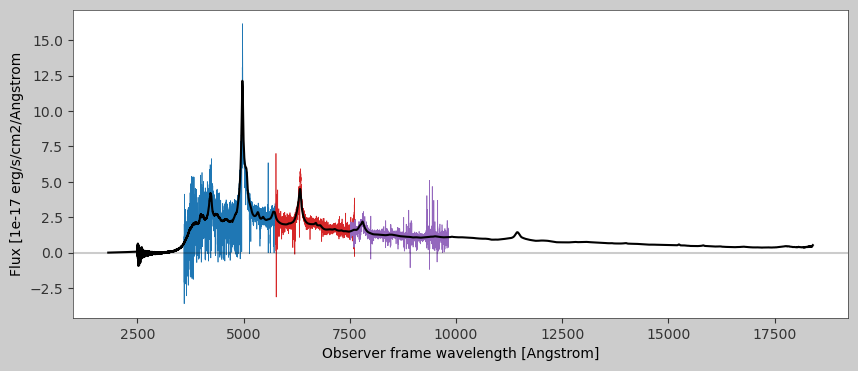

In [163]:
plt.figure(figsize=(10,4))
for camera, color in [('b','C0'), ('r','C3'), ('z', 'C4')]:
    ok = ivar[camera][itgt]>0
    plt.plot(wave[camera][ok], flux[camera][itgt][ok], '-', color=color, lw=0.5)
    
plt.plot(templatewave*(1+z), model, 'k-')
plt.axhline(0, color='k', alpha=0.2)
plt.xlabel('Observer frame wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom')

Note that the template extends well beyond the wavelength range of the data.
Other than the noisy templates at lower redshifts, the extrapolated model looks fairly reasonable.
This is not always the case, especially for the  GALAXY templates with 10 components,
since PCA fits have no constraints that the extrapolated model remain physical.
In particular, the model represent the best PCA fit to the data, but they are not
intended to represent a physical model of the underlying spectrum.

Let's replot, zooming into just the wavelength range covered by the data.

(3500.0, 10000.0)

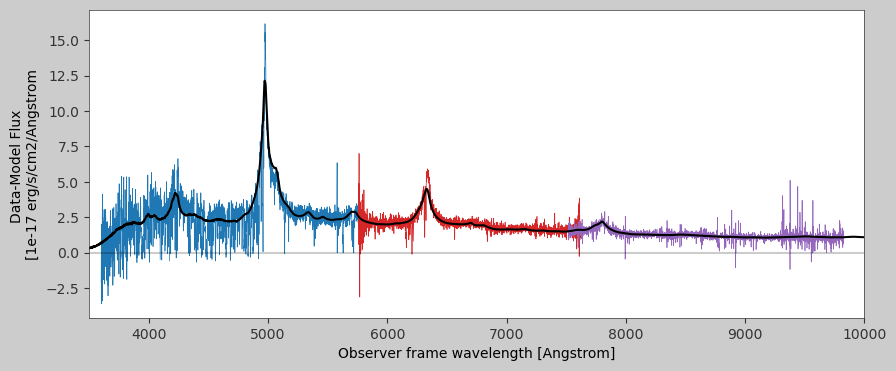

In [164]:
plt.figure(figsize=(10,4))
for camera, color in [('b','C0'), ('r','C3'), ('z', 'C4')]:
    ok = ivar[camera][itgt]>0
    plt.plot(wave[camera][ok], flux[camera][itgt][ok], '-', color=color, lw=0.5)

plt.plot(templatewave*(1+z), model, 'k-')
plt.axhline(0, color='k', alpha=0.2)

plt.xlabel('Observer frame wavelength [Angstrom]')
plt.ylabel('Data-Model Flux \n[1e-17 erg/s/cm2/Angstrom')

plt.xlim(3500, 10000)

Note that although the templates had effectively arbitrary normalization, the combination of coefficients*templates
have meaningful physical units of $10^{-17}$ erg/s/cm$^2$/Angstrom, matching the flux units of the DESI data.

## Using redrock and desispec code to simplify these operations

The above steps of reading the multiple HDUs from the coadd file, filtering them based upon redshift catalog selections,
finding the matching Redrock templates, and generating the corresponding model is admittedly a bit of a hassle.
The packages [desispec](https://github.com/desihub/desispec) and [redrock](https://github.com/desihub/redrock)
provide conveience utilities to simplify these operations.

In [165]:
import redrock.templates
import desispec.io

Generate the paths to the files based upon parameters without having to create format strings by hand:

In [166]:
coaddfile = desispec.io.findfile('coadd', healpix=healpix, survey=survey, faprogram=program, specprod=specprod)
redrockfile = desispec.io.findfile('redrock', healpix=healpix, survey=survey, faprogram=program, specprod=specprod)
print(f'{coaddfile=}')
print(f'{redrockfile=}')

coaddfile='/Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/coadd-main-dark-23040.fits'
redrockfile='/Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/redrock-main-dark-23040.fits'


Read the spectra and redshift catalog, and slice to just the QSOs.
Note that this now just requires one read and one slice operation each, rather than having to read and slice
multiple HDUs.

In [167]:
#- Read
spectra = desispec.io.read_spectra(coaddfile)
zcat = Table.read(redrockfile, 'REDSHIFTS')

#- Select to just the QSOs
keep = (zcat['SPECTYPE'] == 'QSO') & (zcat['ZWARN'] == 0)
spectra = spectra[keep]
zcat = zcat[keep]

INFO:spectra.py:391:read_spectra: iotime 0.377 sec to read coadd-main-dark-23040.fits at 2025-03-13T15:53:30.886253


Read the templates for the requested specprod ("iron" for DR1):

In [168]:
template_dir = redrock.templates.get_template_dir()
templates = redrock.templates.load_templates(f'{template_dir}/templates-{specprod}.txt', asdict=True)

DEBUG: Reading templates from /Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/templates-iron.txt
Reading templates from ['/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-GALAXY-None-v2.6.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-LOZ-v1.0.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-HIZ-v1.0.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-A-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-B-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-CV-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templa

That returns a dictionary of Template objects, keyed by the (SPECTYPE,SUBTYPE) that they represent.

In [169]:
print(templates.keys())
print('QSO HIZ template is:', templates[('QSO', 'HIZ')])
print('STAR F template is:', templates[('STAR', 'F')])

dict_keys([('GALAXY', ''), ('QSO', 'LOZ'), ('QSO', 'HIZ'), ('STAR', 'A'), ('STAR', 'B'), ('STAR', 'CV'), ('STAR', 'F'), ('STAR', 'G'), ('STAR', 'K'), ('STAR', 'M'), ('STAR', 'WD')])
QSO HIZ template is: QSO HIZ PCA IGM=Calura12 z=1.4-6.993
STAR F template is: STAR F PCA IGM=None z=-0.002-0.002


The model for an individual template came be evaluated with:

In [170]:
#- template for this SPECTYPE, SUBTYPE
tx = templates[(zcat['SPECTYPE'][itgt], zcat['SUBTYPE'][itgt])]

#- Coefficients and redshift at which to evaluate the target
coeff = zcat['COEFF'][itgt]
z = zcat['Z'][itgt]

#- Evaluate the model
modelwave = np.arange(3500, 9900)
modelflux = tx.eval(coeff, modelwave, z)

Let's plot that model on top of the data.

(3500.0, 10000.0)

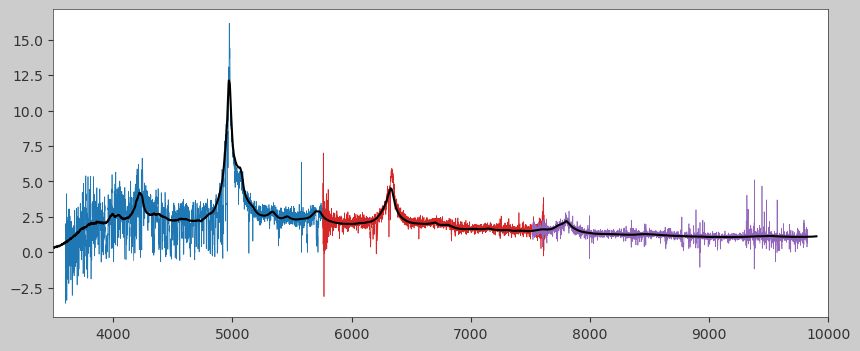

In [171]:
plt.figure(figsize=(10,4))
for camera, color in [('b','C0'), ('r','C3'), ('z', 'C4')]:
    ok = spectra.ivar[camera][itgt]>0
    camwave = spectra.wave[camera][ok]
    plt.plot(camwave, spectra.flux[camera][itgt][ok], '-', color=color, lw=0.5)

plt.plot(modelwave, modelflux, 'k-')

plt.xlim(3500, 10000)

Hopefully that was much easier than reading and manipulating the redrock and coadd files yourself.
However, if you don't want to have your code depend upon `redrock` and `desispec` (which is reasonable!)
you can always work directly with the DESI files using standard tools such as astropy, fitsio, and numpy (or non-Python options too).

## Instrument Resolution

Even that isn't quite right because it calculates the model *before* it is convolved with the DESI spectrograph resolution.
For quasars with broad emission lines, the instrumental resolution is a small effect compared to the natural width of the lines.
The instrumental resolution becomes more important for narrow galaxy emission lines and for narrow stellar absorption.

This will be covered in a separate tutorial [ResolutionMatrix.ipynb](ResolutionMatrix.ipynb).

## Redrock details file

The `redrock-*.fits` file contains the information about the best fit for each target, while additional
information is available in an `rrdetails-*.h5` file, including:
  * $\chi^2$ vs. z scan for each template for each target
  * A table of the best 3 fits for each SPECTYPE

This file is in [hdf5](https://www.hdfgroup.org/solutions/hdf5/) format, which we'll read using the
[h5py](https://docs.h5py.org/en/stable/index.html) library.

In [172]:
import h5py

rrdetailsfile = desispec.io.findfile('rrdetails', healpix=healpix, survey=survey, faprogram=program, specprod=specprod)
print(f'Reading Redrock details from {rrdetailsfile}')

hx = h5py.File(rrdetailsfile)
fullzcat = Table.read(redrockfile, 'REDSHIFTS')

Reading Redrock details from /Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/rrdetails-main-dark-23040.h5


HDF5 files support nested dictionaries of datasets.  At the top level, rrdetails files have
  * *targetids*: an array of TARGETIDs contained in this file
  * *zfit*: tables of the best 3 fits per SPECTYPE for every TARGETID
  * *zscan*: datasets with the $\chi^2$ vs. z scan for each template for each target

In [173]:
hx.keys()

<KeysViewHDF5 ['targetids', 'zfit', 'zscan']>

### targetids

To get the data from an h5py dataset into a numpy array, you have to slice or cast it:

In [174]:
print("hx['targetids'] =", hx['targetids'])
print("hx['targetids'][:] =", hx['targetids'][:])
print("np.array(hx['targetids']) =", np.array(hx['targetids']))

hx['targetids'] = <HDF5 dataset "targetids": shape (1323,), type "<i8">
hx['targetids'][:] = [39627568982263324         -24360048 39627568982265273 ...
 39627563022160869 39627563022160896 39627563026351836]
np.array(hx['targetids']) = [39627568982263324         -24360048 39627568982265273 ...
 39627563022160869 39627563022160896 39627563026351836]


The `targetids` dataset list the order of the targetids in other arrays in this dataset, and
it should match the order of the TARGETIDs in the redrock REDSHIFTS catalog.

In [175]:
np.all(hx['targetids'][:] == fullzcat['TARGETID'])

True

### zscan

Let's start by exploring the zscan data.  There is one entry per SPECTYPE:::SUBTYPE.

In [177]:
hx['zscan'].keys()

<KeysViewHDF5 ['GALAXY', 'QSO:::HIZ', 'QSO:::LOZ', 'STAR:::A', 'STAR:::B', 'STAR:::CV', 'STAR:::F', 'STAR:::G', 'STAR:::K', 'STAR:::M', 'STAR:::WD']>

**Side note**: why 3-colons `:::` as the delimiter?  Redrock also supports archtype fits,
and some of the stellar archetypes inherited from SDSS has colons `:` and commas `,` in their SUBTYPE string,
thus the somewhat clumsy 3-color `:::` delimiter was created.

You can construct these strings yourself, or use the convenience function `redrock.templates.make_fulltype(spectype, subtype)`
to generate the string, which also handles the case of SUBTYPE=None or SUBTYPE=''.

In [178]:
print(redrock.templates.make_fulltype('GALAXY', ''))
print(redrock.templates.make_fulltype('QSO', 'HIZ'))

GALAXY
QSO:::HIZ


Each SPECTYPE:::SUBTYPE has 4 datasets:
  * **redshifts**: the redshifts at which this template was evaluated
  * **chi2**: the $\chi^2$ of the template fit for each target at each redshift
  * **penalty**: a penalty term added to the chi2, currently used only for penalizing negative [OII] fits
  * **zcoeff**: the coefficients of the template fit for each target at each redshift

In [179]:
hx['zscan']['GALAXY'].keys()

<KeysViewHDF5 ['penalty', 'redshifts', 'zchi2', 'zcoeff']>

In [180]:
print('redshifts.shape={} = nredshifts'.format(hx['zscan']['GALAXY']['redshifts'][:].shape))

redshifts.shape=(1446,) = nredshifts


In [181]:
print('zchi2.shape={} = ntarget,nredshifts'.format(hx['zscan']['GALAXY']['zchi2'][:].shape))
print('len(targetids) =', len(hx['targetids'][:]))

zchi2.shape=(1323, 1446) = ntarget,nredshifts
len(targetids) = 1323


In [182]:
print('penalty.shape={} = ntarget,nredshifts'.format(hx['zscan']['GALAXY']['penalty'][:].shape))
print('i.e. same as zchi2.shape')

penalty.shape=(1323, 1446) = ntarget,nredshifts
i.e. same as zchi2.shape


In [183]:
print('zcoeff.shape={} = ntarget,nredshifts,ncoeff'.format(hx['zscan']['GALAXY']['zcoeff'][:].shape))

zcoeff.shape=(1323, 1446, 10) = ntarget,nredshifts,ncoeff


Let's inspect the $\chi^2$ vs. z scan for the QSO that we previously plotted.
Since we had accessed that after filtering the original redshift catalog down to just QSOs,
we'll need to re-establish what index that is in this details file.

In [184]:
targetid = zcat['TARGETID'][itgt]

j = np.where(hx['targetids'][:] == targetid)[0][0]
print(f'TARGETID={targetid} was index {itgt} in the QSO-only catalog, and is index {j} in the full catalog')
assert fullzcat['TARGETID'][j] == targetid

zbest = fullzcat['Z'][j]
spectype = fullzcat['SPECTYPE'][j]

TARGETID=39627563017964714 was index 3 in the QSO-only catalog, and is index 16 in the full catalog


     TARGETID             Z          ZWARN SPECTYPE SUBTYPE     DELTACHI2     
----------------- ------------------ ----- -------- ------- ------------------
39627563017964714 3.0909676562484925     0      QSO     HIZ 26116.075196877122


Text(0.5, 1.0, 'TARGETID 39627563017964714 is QSO at z=3.0910')

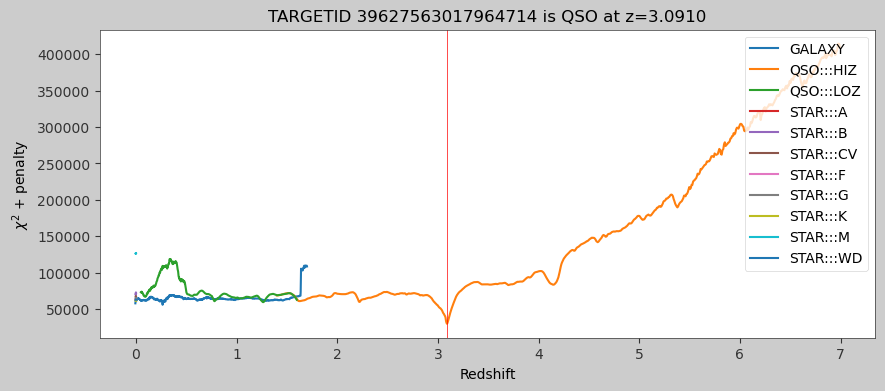

In [185]:
def plot_chi2_scan(zscan, index, legend=False):
    for fulltype in zscan.keys():
        redshifts = zscan[fulltype]['redshifts'][:]
        chi2 = zscan[fulltype]['zchi2'][:][index] + zscan[fulltype]['penalty'][:][index]
        plt.plot(redshifts, chi2, label=fulltype)

    if legend:
        plt.legend(loc='upper right')
        
    plt.xlabel('Redshift')
    plt.ylabel(r'$\chi^2$ + penalty')

print(fullzcat['TARGETID', 'Z', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2'][j])
plt.figure(figsize=(10,4))
plot_chi2_scan(hx['zscan'], j, legend=True)
plt.axvline(zbest, color='r', lw=0.5)
plt.title(f'TARGETID {targetid} is {spectype} at z={zbest:.4f}')

We can see that there is a distinct minimum at the reported redshift for the QSO::HIZ templates for this target.

Let's plot a few more ambiguous cases.

This target has a QSO minimum, but it is much less distinctly the best answer.
Notice the lower DELTACHI2, which is still confident, but not super-confident:

     TARGETID             Z          ZWARN SPECTYPE SUBTYPE     DELTACHI2    
----------------- ------------------ ----- -------- ------- -----------------
39627568982263324 1.9006590933812166     0      QSO     HIZ 34.11856964789331


(8177.191496843472, 8697.191496843472)

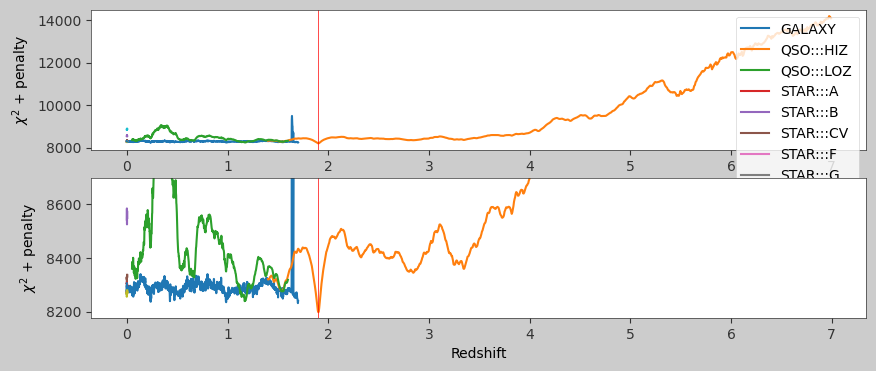

In [188]:
k = 0
print(fullzcat['TARGETID', 'Z', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2'][k])
zbest = fullzcat['Z'][k]
plt.figure(figsize=(10,4))
plt.subplot(211)
plot_chi2_scan(hx['zscan'], k, legend=True)
plt.axvline(zbest, color='r', lw=0.5)
plt.subplot(212)
plot_chi2_scan(hx['zscan'], k)
plt.axvline(zbest, color='r', lw=0.5)
plt.ylim(fullzcat['CHI2'][k]-20, fullzcat['CHI2'][k]+500)

This next target is a galaxy with a sharp minimum.  Note that there are other sharp local minima,
corresponding to line confusion (e.g. mixing up H$\alpha$ with [OIII]).

     TARGETID             Z          ZWARN SPECTYPE SUBTYPE     DELTACHI2     
----------------- ------------------ ----- -------- ------- ------------------
39627568982265273 0.7809855891584742     0   GALAXY      -- 109.36812346428633


(7805.626316420734, 8325.626316420734)

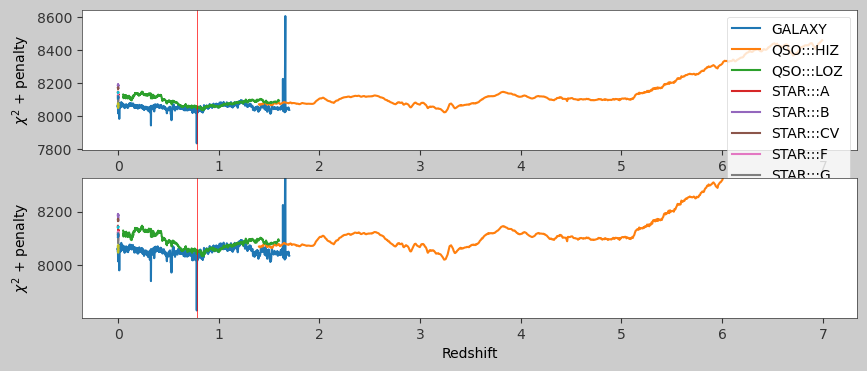

In [189]:
k = 2
print(fullzcat['TARGETID', 'Z', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2'][k])
zbest = fullzcat['Z'][k]
plt.figure(figsize=(10,4))
plt.subplot(211)
plot_chi2_scan(hx['zscan'], k, legend=True)
plt.axvline(zbest, color='r', lw=0.5)
plt.subplot(212)
plot_chi2_scan(hx['zscan'], k)
plt.axvline(zbest, color='r', lw=0.5)
plt.ylim(fullzcat['CHI2'][k]-20, fullzcat['CHI2'][k]+500)

### zfit

Let's look at the zfit table for that target

In [190]:
targetid = hx['targetids'][k]
print(f'Inspecting table of local fit minima for TARGETID={targetid}')

Inspecting table of local fit minima for TARGETID=39627568982265273


The zfit dataset has one key per targetid.
Note that this key is a string, not an integer, since HDF5 requires the dataset keys to be strings.

In [191]:
print(list(hx['zfit'].keys())[0:5], '...')

['-102561162', '-102562014', '-102562020', '-102562046', '-102562049'] ...


In [192]:
hx['zfit'][str(targetid)].keys()

<KeysViewHDF5 ['zfit']>

For reasons that have been lost to the mists of time, we have to go one more level to get the actual table.  Almost there.

In [193]:
#- Get the zfit table
zfit = Table(hx['zfit'][str(targetid)]['zfit'][:])

#- Limit the precision for printing
for col in zfit.colnames:
    if zfit[col].dtype.kind == 'f':
        zfit[col].format = '{:4f}'

zfit

targetid,z,zerr,zwarn,chi2,zz,zzchi2,coeff,npixels,spectype,subtype,ncoeff,znum,deltachi2
int64,float64,float64,int64,float64,float64[15],float64[15],float64[10],int64,bytes6,bytes3,int64,int64,float64
39627568982265273,0.780986,0.000097,0,7825.626316,0.780013 .. 0.782473,7921.164467 .. 7939.031302,63.418836 .. 12.247532,7915,GALAXY,,10,0,109.368123
39627568982265273,0.326022,0.000081,0,7934.994440,0.325327 .. 0.327159,7998.142040 .. 8035.291587,17.448244 .. 2.615839,7915,GALAXY,,10,1,33.062925
39627568982265273,0.530857,0.000058,0,7968.057364,0.529055 .. 0.531169,7982.244689 .. 7979.249458,54.199118 .. -6.315811,7915,GALAXY,,10,2,52.100230
39627568982265273,3.240662,0.001410,0,8020.157595,3.233614 .. 3.243373,8023.583257 .. 8021.835244,0.064387 .. 0.000000,7915,QSO,HIZ,4,3,14.270635
39627568982265273,0.830731,0.000436,4,8034.428229,0.828897 .. 0.833113,8041.473932 .. 8046.142674,0.022761 .. 0.000000,7915,QSO,LOZ,4,4,0.057599
39627568982265273,0.847859,0.000433,4,8034.485828,0.845820 .. 0.850075,8040.175232 .. 8047.837218,0.022226 .. 0.000000,7915,QSO,LOZ,4,5,12.282592
39627568982265273,0.000618,0.000038,0,8046.768420,0.000560 .. 0.000640,8048.476881 .. 8047.026550,17.866151 .. 0.000000,7915,STAR,K,5,6,0.000000
39627568982265273,0.000450,0.000058,0,8082.853289,0.000400 .. 0.000480,8083.646125 .. 8083.135697,12.296453 .. 0.000000,7915,STAR,G,5,7,0.000000
39627568982265273,0.000453,0.000062,0,8092.359812,0.000400 .. 0.000480,8093.065855 .. 8092.562379,15.773239 .. 0.000000,7915,STAR,F,5,8,0.000000


Note that there is one table per target, though the targetid is included a column as a cross check and to facilitate stacking multiple tables.
Unlike the other tables from the FITS-based files, these use lowercase column names.  Otherwise they have the same columns as the redrock files REDSHIFTS table, plus two new columns: `zz` and `zzchi2` giving the fine-grained redshift scan around each minimum, and a `znum` column giving the rank order from best (0) to worst (8).

This table is sorted by chi2 (or equivalently, `znum`).  For this target, it happens to be that the 3 best fits are all GALAXY, followed by 3 QSO fits, followed by 3 STAR fits, but in general they could occur in any order.  In particular, for AGN-like galaxies with both broad and narrow emission lines, it is common to have both a QSO and a GALAXY solution highly ranked at a similar redshift.

## Exercise

* Select a target with ZWARN=4 (low DELTACHI2) in the original fullzcat table.
* Plot its $\chi^2$ vs. z for each template class, and inspect its `zfit` table to see which are the ambiguously close solutions.
* Generate the models for the top two spectype/subtype/z solutions, and plot those on top of the spectral data.
* Can you see why those two solutions are similarly good?
* Is there something else that Redrock or a post-facto analysis could use to determine which is the correct answer, or is the situation genuinely ambiguous given the S/N of the data?